In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=multiprocessing.cpu_count())

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=multiprocessing.cpu_count())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    print("Training on gpu")
    mode = 'cuda'
else:
    print("Training on cpu")
    mode = 'cpu'

Training on gpu


# Exercise 1. Convolutional Neural Networks (CNN)

In [3]:
class ResNetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        if is_last:
            self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), stride=(2, 2), bias=False)
        else:
            self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False)
        self.bn4 = nn.BatchNorm2d(out_channels)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        if in_channels != out_channels and is_last:
            raise Exception("DEBUG")
        
        if in_channels != out_channels:
            self.upsample_filters = True
            self.transform_skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), padding=(0, 0), stride=(1, 1), bias=False)
            self.transform_skip_bn   = nn.BatchNorm2d(out_channels)
        else:
            self.upsample_filters = False
        if is_last:
            self.transform_skip_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(1, 1), padding=(0, 0), stride=(2, 2), bias=False)
            self.transform_skip_bn = nn.BatchNorm2d(out_channels)
        self.is_last = is_last
        
    def forward(self, x):
        x_skip = x
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.bn2(x)
        
        if self.upsample_filters:
            x_skip = self.transform_skip_conv(x_skip)
            x_skip = torch.nn.functional.relu(x_skip)
            x_skip = self.transform_skip_bn(x_skip)
        
        x = x + x_skip
        x_skip = x
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        x = self.bn4(x)
        
        if self.is_last:
            x_skip = self.transform_skip_conv(x_skip)
            x_skip = torch.nn.functional.relu(x_skip)
            x_skip = self.transform_skip_bn(x_skip)
        
        x = x + x_skip
        
        return x



class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n):
        super().__init__()
        layers = []
        layers.append(ResNetBasicBlock(in_channels, out_channels, is_last=False))
        for j in range(2 * n - 2):
            layers.append(ResNetBasicBlock(out_channels, out_channels, is_last=False))
        layers.append(ResNetBasicBlock(out_channels, out_channels, is_last=True))
        self.seq = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.seq(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, in_channels, n):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        # 2 fully connected layers instead of one sho
        self.fc = nn.Linear(1024, 10)
        self.flatten = nn.Flatten()
        self.rn_block1 = ResNetBlock(16, 16 * (2 ** 0), n)
        self.rn_block2 = ResNetBlock(16 * (2 ** 0), 16 * (2 ** 1), n) 
        self.rn_block3 = ResNetBlock(16 * (2 ** 1), 16 * (2 ** 2), n)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.bn1(x)
        x = self.rn_block1(x)
        x = self.rn_block2(x)
        x = self.rn_block3(x)
        x = self.flatten(x) 
        x = self.fc(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

        
clf = ResNet(in_channels=3, n=1).to(mode)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.002, momentum=0.9)

In [4]:
num_epochs = 10

train_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    # epoch
    train_loss = 0
    epoch_iterations = 0
    for x, y in tqdm(trainloader):
        optimizer.zero_grad()
        x, y = x.to(mode), y.to(mode)
        y_pred = clf(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        acc = (torch.argmax(y_pred, dim=1) == y).sum().item() / y.shape[0]
        train_losses.append(loss)
        train_accs.append(acc)
        epoch_iterations += 1
    
    total_val_acc = 0
    test_iterations = 0
    for x, y in tqdm(testloader):
        x, y = x.to(mode), y.to(mode)
        with torch.no_grad():
            y_pred = clf(x)
            acc = (torch.argmax(y_pred, dim=1) == y).sum().item() / y.shape[0]
            total_val_acc += acc
        test_iterations += 1
        
    val_accs.append(total_val_acc / test_iterations)
    print(f"val accuracy at epoch {epoch}: {total_val_acc / test_iterations}")
    print(f"train loss at epoch {epoch}: {train_loss / epoch_iterations}")


  0%|          | 0/391 [00:00<?, ?it/s]

val accuracy at epoch 1: 0.4189082278481013
train loss at epoch 1: 2.160418628731652


  0%|          | 0/391 [00:00<?, ?it/s]

val accuracy at epoch 2: 0.481309335443038
train loss at epoch 2: 2.0048002525973505


  0%|          | 0/391 [00:00<?, ?it/s]

val accuracy at epoch 3: 0.5291732594936709
train loss at epoch 3: 1.9452421872512153


  0%|          | 0/391 [00:00<?, ?it/s]

val accuracy at epoch 4: 0.5586431962025317
train loss at epoch 4: 1.9021990113246166


  0%|          | 0/391 [00:00<?, ?it/s]

val accuracy at epoch 5: 0.5795094936708861
train loss at epoch 5: 1.8663198582046783


  0%|          | 0/391 [00:00<?, ?it/s]

val accuracy at epoch 6: 0.5955300632911392
train loss at epoch 6: 1.8341287679379554


  0%|          | 0/391 [00:00<?, ?it/s]

val accuracy at epoch 7: 0.6184731012658228
train loss at epoch 7: 1.807087981182596


  0%|          | 0/391 [00:00<?, ?it/s]

val accuracy at epoch 8: 0.629746835443038
train loss at epoch 8: 1.7817401712202965


  0%|          | 0/391 [00:00<?, ?it/s]

val accuracy at epoch 9: 0.6401305379746836
train loss at epoch 9: 1.7576821920511974


100%|██████████| 79/79 [00:01<00:00, 62.87it/s]

val accuracy at epoch 10: 0.6509098101265823
train loss at epoch 10: 1.735085286142881


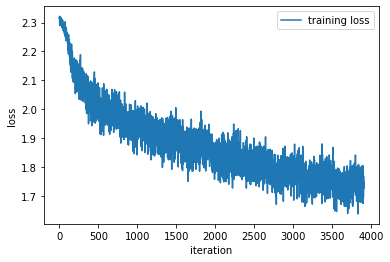

In [5]:
plt.plot(list(range(len(train_losses))), train_losses, label="training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

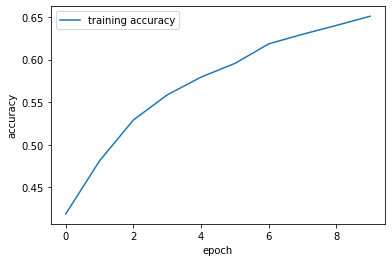

In [9]:
plt.plot(list(range(len(val_accs))), val_accs, label="training accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## (a) Plot the filters of the first layer. What kind of features do they extract?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

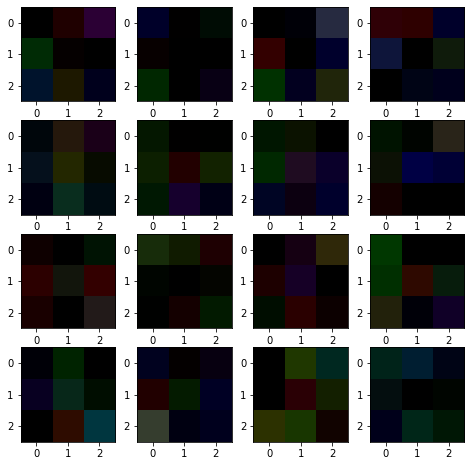

In [10]:
filters = clf.conv1.weight.detach().cpu().clone().numpy()

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = filters[i - 1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## c) Is deeper always better? Provide some evidence for your answer and explain why that is the case.

In theory it should be better, since our network can learn more complex functions, however in practise it makes the network overfit faster, makes the network suffer from the vanishing gradient problem and increases computational complexity.